# ASL image recognition with Deep Learning

## Introduction

In North America, American Sign Language (ASL), is the primary means of communication for many deaf people. Recently, great progress has been made in the development of computer vision systems that translate sign language to spoken English.

This technique usually employs highly advanced neural network that can detect patterns in video streams. However, as a first step in learning how to build a translation system, we may reduce the difficulty by translating individual letters rather than whole words.

My objective is to create a deep learning model that can accurately recognize letters from a large dataset of ASL picture collections.

### Loading dependencies and datasets

In the code below I will load the asl alphabet dataset. This dataset will be used to train the conventional neural network.

In order to download the kaggle dataset a kaggle.json is needed. After the json has been verified we can download the kaggle dataset and unzip it. This will result in 2 new files:
- asl_alphabet_test
- asl_alphabet_train

In [ ]:
import os
!pip install -q kaggle #import kaggle api

from google.colab import files

if os.path.exists('/content/kaggle.json') == False:
  files.upload()

!cp kaggle.json ~/.kaggle/ #copy kaggle.json file
!chmod 600 ~/.kaggle/kaggle.json #change the permision of the file

#test that everything is running ok
!kaggle datasets download -d grassknoted/asl-alphabet
!unzip asl-alphabet.zip

After loading the datset, we now need a location to save all the libraries we'll require for this project.

In [ ]:
import os #this is here so i dont have to run the first code block everytime collab crashes >:(

import numpy as np
from numpy.random import seed


import cv2 #for reading images using path

from sklearn.model_selection import train_test_split #test train split
from sklearn.utils import shuffle #shuffle data

import matplotlib.pyplot as plt #for plotting & data visualization

#for building a CNN using keras
from tensorflow import keras
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Conv2D, Dense, Dropout, Flatten
from keras.layers import Flatten, Dense
from keras.models import Sequential

#for error analysis
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn.metrics import ConfusionMatrixDisplay

### Loading the data and creating labels 

In the code below we will be loading the training data. Using the training data we will create 2 lists; one containing features and another containing labels.

- features will contain the arrays of images(paths)
- labels will contain the category labels

I woud like preserved every image in the list since we typically want as much data as we can when training these models. It's vital to keep in mind, though, that in some situations, the amount of the data is not as significant as the changes in the data samples.(high variation)

In this instance, I'll preserve only 500 data samples, but if time were not an issue, it could be a good idea to not limit the dataset and use all samples possible.


In [ ]:
features = []
labels = []

classes = ["A","B","C","D","E","F","G","H","I","J","K","L","M","N","O","P","Q","R","S","T","U","V","W","X","Y","Z","del","nothing","space"]

# create a path that represents each class directory
for i in range(len(classes)):
  path = "/content/asl_alphabet_train/asl_alphabet_train/" + classes[i]
  dir_list = os.listdir(path)

  #append path to features list and appent classification to labels list
  for item in range(500): 
    features.append("/content/asl_alphabet_train/asl_alphabet_train/" + classes[i] + "/" + dir_list[item])
    labels.append([i])

#print list sizes
print("Feature size: ", len(features))
print("Labels size: ", len(labels))


Feature size:  14500
Labels size:  14500


Since we have now taken the features and labels out of the dataset, we can utilize them to determine the train-test split.

As usuall we will split the data into x_train, y_train, x_test and y_test.

In [ ]:
features,labels = shuffle(features,labels,random_state=0)

In [ ]:
x_train, y_train, x_test, y_test = [], [], [], []

#use cv2 to read image features and then reshape image to 200 x 200 x 3. 
for i in features:
    x_train.append(cv2.imread(i,cv2.IMREAD_COLOR))
    x_train[-1] = np.reshape(x_train[-1],[200,200,3])

#append labels to y_train
for i in labels:
    y_train.append(i)

x_train,x_test,y_train,y_test = train_test_split(x_train,y_train,test_size=0.3)

#print shapes
print('x_train shape: ', np.shape(x_train))
print('y_train shape: ', np.shape(y_train))
print('x_test shape: ', np.shape(x_test))
print('y_test shape: ', np.shape(y_test))



x_train shape:  (10150, 200, 200, 3)
y_train shape:  (10150, 1)
x_test shape:  (4350, 200, 200, 3)
y_test shape:  (4350, 1)


Great, now we have the shape of our train test split. 
- x_train and x_test both have a shape of (num_examples, 200, 200, 3)
- y_train and y_test both have a shape of (num_examples, 1)

Now that the training and test data have been separated, we can begin to view the training data.

## Data analysis & finding a baseline


### Displaying the data we are working with 


Let's start out by looking at every letter in the alphabet. We can accomplish this by putting a label next to an image of an ASL letter.

In [2]:
unique,count = np.unique(y_train,return_counts=True)
num_count = 1
plt.figure(figsize=(20,20))

#print an image of each unique label
for i in unique:
    plt.subplot(10,3,num_count)
    plt.imshow(x_train[np.where(y_train == np.array(i))[0][0]])
    plt.axis('off')
    plt.title(classes[i])
    num_count += 1

NameError: ignored

Plotting these images along the relevant class axis helps us understand the data we are dealing with. We can identify trends thanks to this data visualization, which also enables us to comprehend the meaning of the data.

### Finding the baseline 


Let's see how many images there are in the collection for each letter. Considering that the dataset has already been split into training and test sets, finding a fundamental baseline for our model shouldn't be too difficult.

In order to find our baseline we will take the number of samples of each class in our dataset and plot them.

Keep in mind that a baseline shouldn't need you to train any models, but it should enable you to determine whether the work your trained models are performing is beneficial to the outcome.

In [ ]:
plt.bar(unique, count, tick_label = classes, width = 0.8, color =['red', 'blue'])
#naming the x-axis
plt.xlabel('Class')
#naming the y-axis
plt.ylabel('Number of images')
#title
plt.title('Image count')

This graphic demonstrates that our dataset has an almost equal number of examples for each type of class. This data may be used to establish the baseline against which we will evaluate the effectiveness of our model.

Obtaining the mean or median is one of the simplest approaches to establish a baseline for our model. This simply implies that for each observation in the dataset, you would forecast the median value of the outcome variable.

Lets do some quick math to help us determine the outcome.

In [ ]:
total_count = sum(count)

for un in unique:
  print('Class: ', classes[un], 'Count: ', count[un], 'Mean Probability: ', count[un]/total_count)


As you can see, there is about a 3.5% chance that a random guess will result in the right letter. This makes sense when you consider that the probability of selecting the proper class at random is 1/29.

## Building the model

Now that the data has been categorized, a convolutional neural network has to be defined. In order to comprehend how to construct a CNN that is more effective, we will be developing three of these networks. These networks accept as input a picture of an alphabet in American Sign Language. The network's projected probability that the picture belongs in each category are returned by the output layer.

### Experiment 1

#### Reasoning

The keras.Sequential() approach, which I shall employ, works best when applying straightforward stacks of layers with a single input and output tensor.

Then, two 2D convolution layers will be passed, which will build the groundwork for our convolutional neural network.

The input will be flattened at the end, a dense layer with a softmax activation will be added, and a sophisticated optimizer will also be included. 'Adam' in this instance.

Given that this is a fundamental convolutional neural network, I anticipate reasonable outcomes with an accuracy of between 70% and 90%.

#### Model

In [ ]:
model = keras.Sequential()

model.add(keras.layers.Conv2D(16,(3,3),activation="relu",padding="same",input_shape=(200,200,3)))
model.add(keras.layers.MaxPooling2D(3,3))

model.add(keras.layers.Conv2D(32,(3,3),activation="relu",padding="same"))
model.add(keras.layers.MaxPooling2D(3,3))

model.add(keras.layers.Flatten())

model.add(keras.layers.Dense(29,activation="softmax"))

opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt,loss="sparse_categorical_crossentropy",metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 200, 200, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 66, 66, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 66, 66, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 22, 22, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 15488)             0         
                                                                 
 dense (Dense)               (None, 29)                4

#### Analysis

In [ ]:
#turn our lists into numpy arrays so we can insert them into our model 
x_train = np.array(x_train)
y_train = np.array(y_train) 
x_test = np.array(x_test)
y_test = np.array(y_test)

#start fitting our model @ 10 epochs
history = model.fit(x_train,
          y_train,
          epochs=10, 
          validation_data = (x_test,y_test))

Epoch 1/10
318/318 [==============================] - 234s 735ms/step - loss: 16.2856 - accuracy: 0.3483 - val_loss: 1.2708 - val_accuracy: 0.6097
Epoch 2/10
318/318 [==============================] - 228s 717ms/step - loss: 0.8592 - accuracy: 0.7246 - val_loss: 1.0065 - val_accuracy: 0.7062
Epoch 3/10
318/318 [==============================] - 232s 730ms/step - loss: 0.4871 - accuracy: 0.8389 - val_loss: 0.9162 - val_accuracy: 0.7515
Epoch 4/10
318/318 [==============================] - 225s 707ms/step - loss: 0.3237 - accuracy: 0.8904 - val_loss: 0.9608 - val_accuracy: 0.7710
Epoch 5/10
318/318 [==============================] - 234s 737ms/step - loss: 0.2475 - accuracy: 0.9176 - val_loss: 0.9553 - val_accuracy: 0.7745
Epoch 6/10
318/318 [==============================] - 227s 713ms/step - loss: 0.2337 - accuracy: 0.9233 - val_loss: 1.2268 - val_accuracy: 0.7455
Epoch 7/10
318/318 [==============================] - 225s 707ms/step - loss: 0.1837 - accuracy: 0.9409 - val_loss: 1.0630 

We get an accuracy of roughly 95% after 10 iterations, which actually outperforms my initial projections for the model. However, this does raise some important issues, such as what would happen if we altered the size of the kernal or convolutional layer filter.

Given that the size has significantly shrunk, I would anticipate a loss of features, which would inescapably result in a loss of accuracy.

Lets now take a look at out train/test loss and train/test accuracy over the course of the 10 epochs.

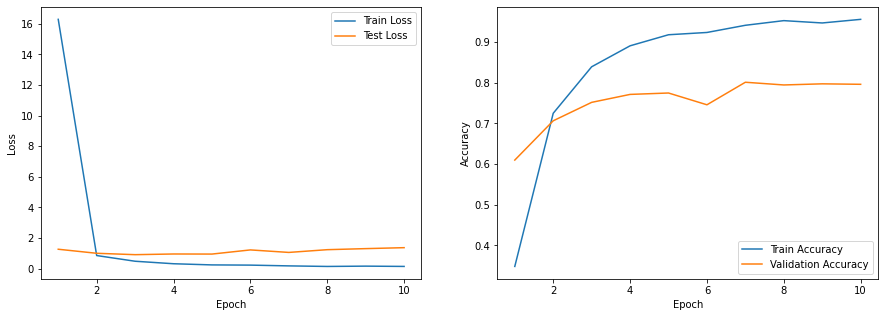

In [ ]:
#get values from history
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val accuracyuracy']

#create a count for the number of epochs (x axis)
epoch_count = range(1, len(loss) + 1)

#train and test loss plot
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(epoch_count, loss)
plt.plot(epoch_count, val_loss)
plt.legend(['Train Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')

#train and val acc plot
plt.subplot(1,2,2)
plt.plot(epoch_count, accuracy)
plt.plot(epoch_count, val_accuracy)
plt.legend(['Train Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

We can see that there was a large amount of train loss on the first epoch, and that the loss decreased steadily from 0.8 to 0.1 after the second epoch.

After the first epoch, you can observe that there is a very high degree of accuracy because of the loss patterns. After then, this precision gradually rises, like the peak of a logarithmic growth curve.

### Experiment 2

#### Reasoning

Let's now experiment with the convolutional layers' filter size. I believe that by altering the size to be smaller, we will eventually lose elements that are crucial to the model used to categorize the photographs. Ultimately causing an accuracy decrease.

However, I also belive that by adding 2 back to back 2d convolutions we might be able to preserve important details about the features we are extracting which help keep our results high and our training time low.

#### Model

In [ ]:
model = keras.Sequential()

model.add(keras.layers.Conv2D(8,(3,3),activation="relu",padding="same", input_shape=(200,200,3)))
model.add(keras.layers.Conv2D(8,(3,3),activation="relu",padding="same", input_shape=(200,200,3)))
model.add(keras.layers.MaxPooling2D(3,3))

model.add(keras.layers.Conv2D(16,(3,3),activation="relu",padding="same"))
model.add(keras.layers.Conv2D(16,(3,3),activation="relu",padding="same"))
model.add(keras.layers.MaxPooling2D(3,3))

model.add(keras.layers.Flatten())

model.add(keras.layers.Dense(29,activation="softmax"))

opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt,loss="sparse_categorical_crossentropy",metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 200, 200, 8)       224       
                                                                 
 conv2d_11 (Conv2D)          (None, 200, 200, 8)       584       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 66, 66, 8)        0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 66, 66, 16)        1168      
                                                                 
 conv2d_13 (Conv2D)          (None, 66, 66, 16)        2320      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 22, 22, 16)       0         
 2D)                                                  

#### Analysis

In [ ]:
#turn our lists into numpy arrays so we can insert them into our model 
x_train = np.array(x_train)
y_train = np.array(y_train) 
x_test = np.array(x_test)
y_test = np.array(y_test)

#start fitting our model @ 10 epochs
history = model.fit(x_train,
          y_train,
          epochs=10, 
          validation_data = (x_test,y_test))

Epoch 1/10
318/318 [==============================] - 403s 1s/step - loss: 4.7494 - accuracy: 0.3095 - val_loss: 1.3834 - val_accuracy: 0.5554
Epoch 2/10
318/318 [==============================] - 390s 1s/step - loss: 0.8073 - accuracy: 0.7484 - val_loss: 0.8199 - val_accuracy: 0.7457
Epoch 3/10
318/318 [==============================] - 392s 1s/step - loss: 0.3892 - accuracy: 0.8754 - val_loss: 0.6982 - val_accuracy: 0.7910
Epoch 4/10
318/318 [==============================] - 392s 1s/step - loss: 0.2304 - accuracy: 0.9242 - val_loss: 0.7065 - val_accuracy: 0.8143
Epoch 5/10
318/318 [==============================] - 395s 1s/step - loss: 0.1373 - accuracy: 0.9542 - val_loss: 0.6971 - val_accuracy: 0.8260
Epoch 6/10
318/318 [==============================] - 394s 1s/step - loss: 0.1122 - accuracy: 0.9617 - val_loss: 0.8351 - val_accuracy: 0.8133
Epoch 7/10
318/318 [==============================] - 416s 1s/step - loss: 0.1082 - accuracy: 0.9665 - val_loss: 0.8164 - val_accuracy: 0.8356

As you can see we are able to decrease our loss across epochs. Our first model had a loss of 16.2856 down to 0.1856. This second experimental model now has a loss of 4.7494 down to 0.0767. This change in loss brings us to a new and better accuracy of 0.9744.

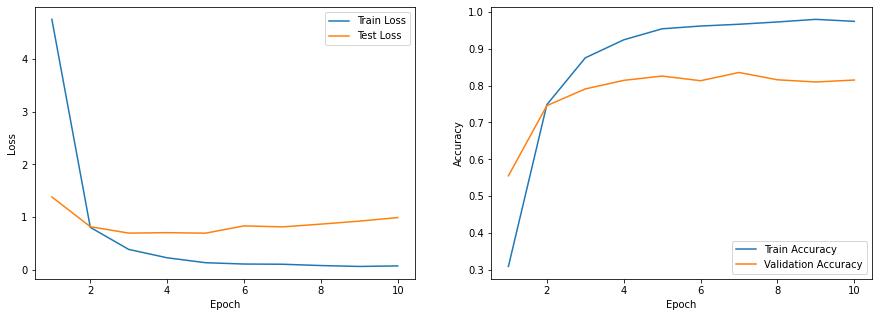

In [ ]:
#get values from history
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val accuracyuracy']

#create a count for the number of epochs (x axis)
epoch_count = range(1, len(loss) + 1)

#train and test loss plot
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(epoch_count, loss)
plt.plot(epoch_count, val_loss)
plt.legend(['Train Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')

#train and val acc plot
plt.subplot(1,2,2)
plt.plot(epoch_count, accuracy)
plt.plot(epoch_count, val_accuracy)
plt.legend(['Train Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

We can see here that our training loss function resembles something similar to f(x) = 1/x. Very similar to the training loss in Experiment 1, however we start at a significantly lower loss and end at a higher accuracy.

### Experiment 3

#### Reasoning

Let's carry on with our tests by adding another dense layer, then a dropout layer.

The outputs from our flatten layer will simply be entered into a dense layer.

Now we'll add a dropout layer that will randomly set inputs to 0 with a 0.5 frequency in order to prevent overfitting.

#### Model

In [ ]:
model = keras.Sequential()

model.add(keras.layers.Conv2D(8,(3,3),activation="relu",padding="same", input_shape=(200,200,3)))
model.add(keras.layers.Conv2D(8,(3,3),activation="relu",padding="same"))
model.add(keras.layers.MaxPooling2D(3,3))

model.add(keras.layers.Conv2D(16,(3,3),activation="relu",padding="same"))
model.add(keras.layers.Conv2D(16,(3,3),activation="relu",padding="same"))
model.add(keras.layers.MaxPooling2D(3,3))

model.add(keras.layers.Flatten())

model.add(keras.layers.Dense(968,activation="relu"))
model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Dense(29,activation="softmax"))

opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt,loss="sparse_categorical_crossentropy",metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 200, 200, 8)       224       
                                                                 
 conv2d_3 (Conv2D)           (None, 200, 200, 8)       584       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 66, 66, 8)        0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 66, 66, 16)        1168      
                                                                 
 conv2d_5 (Conv2D)           (None, 66, 66, 16)        2320      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 22, 22, 16)       0         
 2D)                                                  

#### Analysis

In [ ]:
#turn our lists into numpy arrays so we can insert them into our model 
x_train = np.array(x_train)
y_train = np.array(y_train) 
x_test = np.array(x_test)
y_test = np.array(y_test)

#start fitting our model @ 10 epochs
history = model.fit(x_train,
          y_train,
          epochs=10, 
          validation_data = (x_test,y_test))

Epoch 1/10
318/318 [==============================] - 513s 2s/step - loss: 3.8453 - accuracy: 0.3300 - val_loss: 0.9694 - val_accuracy: 0.7152
Epoch 2/10
318/318 [==============================] - 472s 1s/step - loss: 0.8149 - accuracy: 0.7429 - val_loss: 0.5265 - val_accuracy: 0.8432
Epoch 3/10
318/318 [==============================] - 473s 1s/step - loss: 0.4061 - accuracy: 0.8691 - val_loss: 0.3890 - val_accuracy: 0.8743
Epoch 4/10
318/318 [==============================] - 470s 1s/step - loss: 0.2454 - accuracy: 0.9182 - val_loss: 0.3138 - val_accuracy: 0.8986
Epoch 5/10
318/318 [==============================] - 460s 1s/step - loss: 0.1898 - accuracy: 0.9352 - val_loss: 0.2832 - val_accuracy: 0.9092
Epoch 6/10
318/318 [==============================] - 461s 1s/step - loss: 0.1325 - accuracy: 0.9557 - val_loss: 0.4069 - val_accuracy: 0.8775
Epoch 7/10
318/318 [==============================] - 453s 1s/step - loss: 0.1622 - accuracy: 0.9468 - val_loss: 0.3163 - val_accuracy: 0.9005

We can see that there is a new accuracy of 0.9761 now that we have the dense and dropout layers to deal with the overfitting. Considering the quantity of neurons and the size of the inputs, this model still performs rather well, even if it is nowhere near 99%.

If we built a convolution with four to five layers, it may be closer to 99 percent accuracy. But training on such model would take a lot longer.

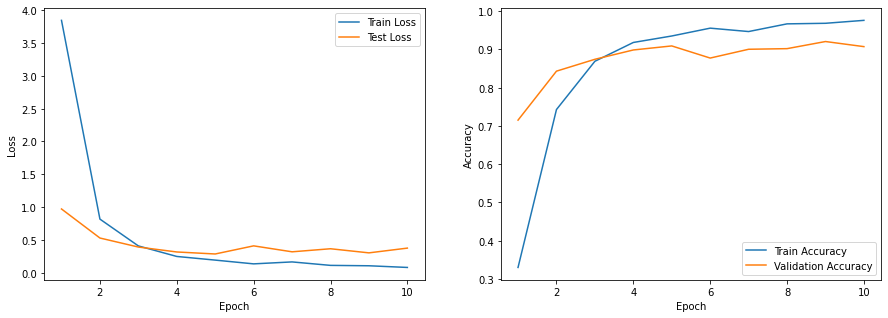

In [ ]:
#get values from history
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

#create a count for the number of epochs (x axis)
epoch_count = range(1, len(loss) + 1)

#train and test loss plot
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(epoch_count, loss)
plt.plot(epoch_count, val_loss)
plt.legend(['Train Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')

#train and val acc plot
plt.subplot(1,2,2)
plt.plot(epoch_count, accuracy)
plt.plot(epoch_count, val_accuracy)
plt.legend(['Train Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

## Error Analysis


We may try to identify the areas where our model is having trouble identifying ASL letters by conducting some simple error analysis.

136/136 [==============================] - 56s 409ms/step


<Figure size 3600x3600 with 0 Axes>

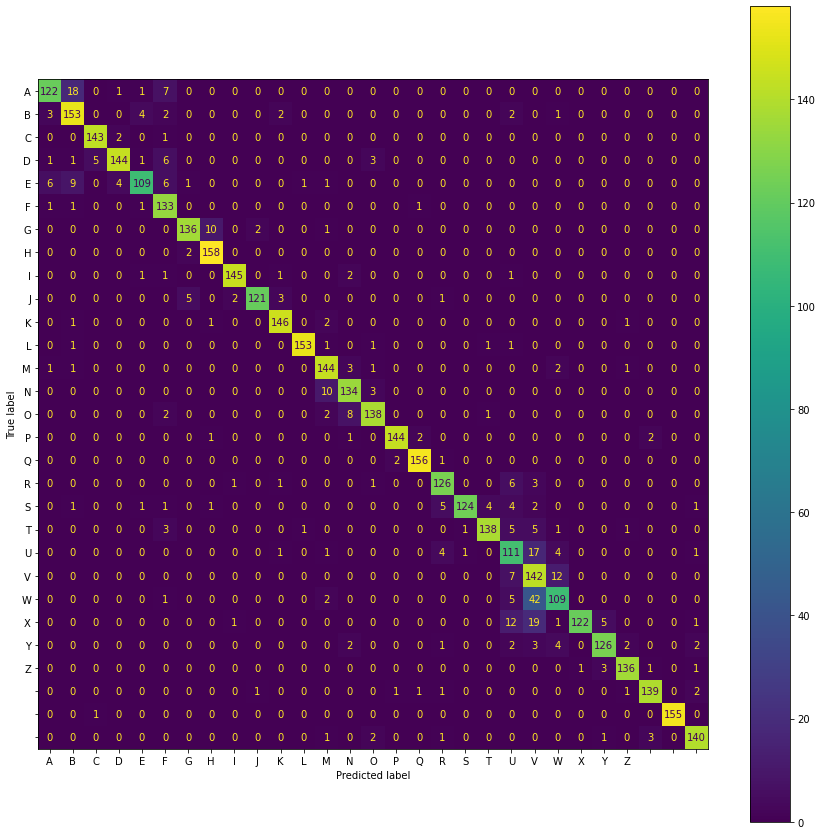

In [ ]:
plt.figure(figsize=(50,50))

y_pred = np.argmax(model.predict(x_test),1)
alpha = [chr(c) for c in range(65,91)] #used to label the alphabet

cm = confusion_matrix(y_test, y_pred.reshape(-1,1))

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=alpha) #display labels set to alphabet
fig, ax = plt.subplots(figsize=(15,15)) 
disp.plot(ax=ax) #display plot

We can see that the CNN is having the greatest problems recognizing ws from vs, it is alot easier to notice this when printing the condusion matrix as we are able to locate where exactly the misrepresentations are happening. Which makes sense considering how similar w and v seem in the ASL images for both letters. The amount of fingers you hold up when doing that is the only variation.

## Conclusion


There are many improvements that can be done to the dataset beyond this one straightforward method in order to improve the model's performance.

Some of these adjustments include utilizing a bigger dataset, for example. In this illustration, we kept the number of elements in each class to around 500. Each class has a total of roughly 3000 photos. This would need a big increase in our training time, but I think the training outcome would have greater accuraccy.

We can also consider greating new architectures for our convolutional networks, perhaps having many convolutions with different shapes will help with feature recognition.